### 1. Importación de librerías

En esta primera sección importamos las librerías fundamentales que se utilizarán durante todo el proyecto:

- **NumPy**: para operaciones matemáticas y manipulación de arreglos.
- **Matplotlib**: para generar visualizaciones y gráficas.
- **TensorFlow/Keras**: para construir, entrenar y evaluar los modelos de redes neuronales.
- **OpenCV**: para el procesamiento de imágenes, especialmente para la parte del sistema de reconocimiento en tiempo real.


In [1]:
# Basic imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

### 2. Carga del directorio del dataset

En esta sección se define la ruta local donde se encuentra el dataset personalizado de dígitos manuscritos. 
Utilizamos `pathlib.Path` para manejar rutas de manera más segura y legible.  
El código imprime el directorio que será utilizado y verifica que existan las subcarpetas correspondientes a cada clase tanto en *Train* como en *Test*.  
Esto permite confirmar que el dataset está correctamente estructurado antes de comenzar el preprocesamiento.


In [ ]:
from pathlib import Path

data_dir = Path("C:\\UDEM\\Semestre5\\IA\\CNNproyecto\\Numbers")

print("Usando directorio:", data_dir)

print("Subcarpetas en train:", [p.name for p in (data_dir/'Train').iterdir()])
print("Subcarpetas en test:",  [p.name for p in (data_dir/'Test').iterdir()])


Usando directorio: C:\UDEM\Semestre5\IA\CNNproyecto\Numbers
Subcarpetas en train: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Subcarpetas en test: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


### 3. Construcción del conjunto de datos y preprocesamiento

En esta sección se genera el conjunto de datos a partir de las carpetas locales del proyecto.  
El dataset contiene imágenes de dígitos manuscritos capturados por estudiantes, distribuidos en:

- **Train/**: usado para entrenar el modelo  
- **Test/**: usado únicamente para evaluar el desempeño final

Cada carpeta contiene subcarpetas del `0` al `9`, donde cada imagen pertenece a su clase correspondiente.  
Para facilitar el entrenamiento se crea un *data pipeline* con `image_dataset_from_directory`.

---

#### **3.1 Creación de los datasets**

Se generan tres conjuntos:

- **train_ds** — 70% del conjunto *Train*, usado para entrenamiento  
- **val_ds** — 30% restante, usado para validación  
- **test_ds** — imágenes completamente nuevas (nunca vistas durante el entrenamiento)

Todas las imágenes se cargan como escala de grises y se redimensionan a 28×28 px para mantener compatibilidad con arquitecturas tipo MNIST.

---

#### **3.2 Normalización**

Las imágenes se normalizan al rango \([0,1]\) dividiendo entre 255.  
Además, se aplica una inversión de color (`1.0 - image`) porque los dígitos del dataset son:

- oscuros sobre fondo claro, pero el modelo funcionaba mejor aprendiendo números claros sobre fondo oscuro.

Esto mejora la estabilidad del entrenamiento.

---

#### **3.3 Aumento de datos (Data Augmentation)**

Para mejorar la generalización del modelo y simular variaciones reales en la escritura, se aplican transformaciones aleatorias únicamente al conjunto de entrenamiento:

- **Rotaciones pequeñas (±10%)**  
- **Zoom aleatorio**  
- **Traslaciones horizontales y verticales**  

Estas operaciones ayudan al modelo a volverse más robusto ante números mal alineados o ligeramente deformados.

---

#### **3.4 Optimización del pipeline**

Finalmente, los datasets pasan por `prefetch(AUTOTUNE)` para permitir que TensorFlow prepare el siguiente batch mientras el modelo entrena, acelerando considerablemente el proceso.

Este pipeline deja listo un flujo eficiente y completamente preprocesado de imágenes para construir y entrenar los diferentes modelos de CNN.


In [ ]:
import tensorflow as tf
from pathlib import Path

img_size = (28, 28)
batch_size = 64

data_dir = Path("C:\\UDEM\\Semestre5\\IA\\CNNproyecto\\Numbers")

# 1. Crear datasets a partir de las carpetas
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir / "Train",
    color_mode="grayscale",
    image_size=img_size,
    batch_size=batch_size,
    validation_split=0.3,
    subset="training",
    seed=42,
    label_mode="categorical"
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir / "Train",
    color_mode="grayscale",
    image_size=img_size,
    batch_size=batch_size,
    validation_split=0.3,
    subset="validation",
    seed=42,
    label_mode="categorical"
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir / "Test",
    color_mode="grayscale",
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False,
    label_mode="categorical"
)

print("Clases:", train_ds.class_names)

# 2. Normalizar a [0,1]
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    # invertimos los colores
    image = 1.0 - image
    return image, label

train_ds = train_ds.map(preprocess)
val_ds   = val_ds.map(preprocess)
test_ds  = test_ds.map(preprocess)

# 3. Data augmentation en train
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# 4. Prefetch para acelerar
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.prefetch(tf.data.AUTOTUNE)
test_ds  = test_ds.prefetch(tf.data.AUTOTUNE)


Found 7100 files belonging to 10 classes.
Using 4970 files for training.
Found 7100 files belonging to 10 classes.
Using 2130 files for validation.
Found 1866 files belonging to 10 classes.
Clases: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


### 4. Visualización de ejemplos del conjunto de entrenamiento

Antes de entrenar los modelos, es importante inspeccionar visualmente algunas imágenes para confirmar que el preprocesamiento y el pipeline de carga funcionan correctamente.

En esta celda:

1. Se extrae un batch del conjunto `train_ds` usando `next(iter(train_ds))`.
2. Se imprimen las dimensiones del batch:
   - `images.shape` indica la forma `(batch_size, 28, 28, 1)`
   - `labels.shape` corresponde a la codificación *one-hot* de las clases
3. Se muestran cinco imágenes del batch:
   - Cada imagen se convierte a matriz NumPy con `.numpy()`
   - Se usa `squeeze()` para remover el canal adicional
   - Se visualizan en escala de grises
   - Se muestra el vector *one-hot* correspondiente al 1 cuya posicion indica el numero  (estando ordenado de forma ascendente, del 0 al 9)

Esta inspección permite verificar:
- Que las imágenes hayan sido correctamente redimensionadas
- Que la normalización e inversión se aplicaron adecuadamente
- Que las etiquetas correspondan correctamente a los dígitos cargados desde las carpetas



(64, 28, 28, 1) (64, 10)


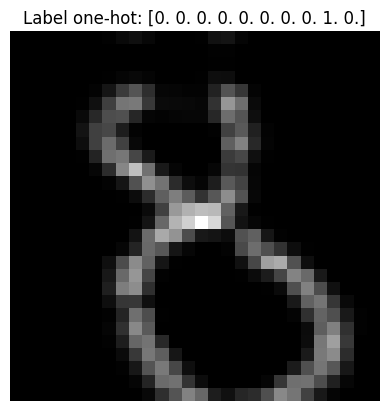

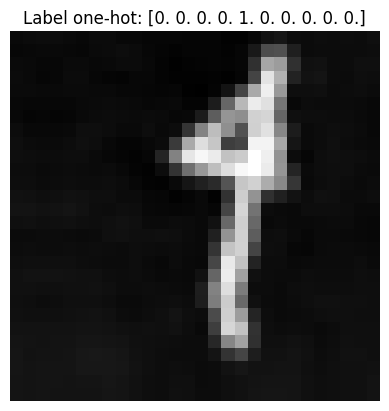

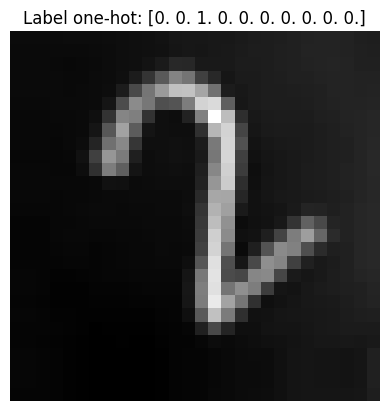

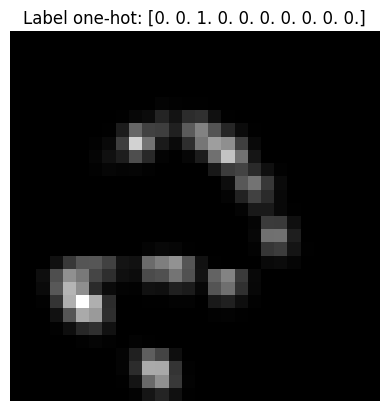

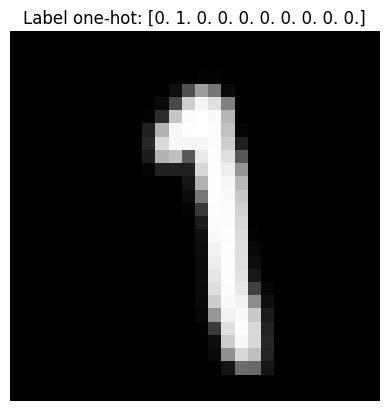

In [4]:
images, labels = next(iter(train_ds))

print(images.shape, labels.shape)
for i in range(5):
    plt.imshow(images[i].numpy().squeeze(), cmap='gray')
    plt.title(f"Label one-hot: {labels[i].numpy()}")
    plt.axis('off')
    plt.show()


### 5. Definición de la arquitectura CNN base

En esta sección se construye el modelo convolucional principal que servirá como referencia para comparar con las demás arquitecturas alternativas. El modelo se implementa con `tf.keras.Sequential`, y está compuesto por las siguientes capas:

#### **5.1 Capas convolucionales**
1. **Conv2D (32 filtros, 3×3, ReLU, padding='same')**  
   - Extrae patrones locales como bordes o trazos de los dígitos.  
   - El padding ‘same’ conserva el tamaño espacial de la imagen.

2. **MaxPooling2D (2×2)**  
   - Reduce a la mitad las dimensiones del mapa de características.  
   - Ayuda a disminuir el ruido y evitar el sobreajuste.

3. **Conv2D (64 filtros, 3×3, ReLU)**  
   - Extrae características más complejas, como curvas o cambios de grosor.

4. **MaxPooling2D (2×2)**  
   - Continúa reduciendo la dimensionalidad y conservando la información relevante.

5. **Conv2D (128 filtros, 3×3, ReLU)**  
   - Última capa convolucional, enfocada en capturar patrones de alto nivel propios de cada dígito.

---

#### **5.2 Capas densas (fully connected)**

- **Flatten**  
  Convierte los mapas de características en un vector unidimensional para la etapa de clasificación.

- **Dense(64, ReLU)**  
  Actúa como capa intermedia para aprender combinaciones no lineales de las características extraídas.

- **Dropout(0.3)**  
  Apaga aleatoriamente el 30% de las neuronas durante el entrenamiento.  
  Su propósito es reducir el *overfitting* y mejorar la capacidad de generalización del modelo.

- **Dense(10, softmax)**  
  Capa final de clasificación.  
  Produce un vector de 10 probabilidades correspondientes a cada dígito (0–9).

---

#### **5.3 Compilación**

El modelo se compila con:

- **Optimizador:** `Adam`, utilizado por su eficiencia y estabilidad.  
- **Función de pérdida:** `categorical_crossentropy`, adecuada para clasificación multiclase.  
- **Métrica:** `accuracy`, para evaluar precisión durante entrenamiento y validación.



In [5]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(28,28,1)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(10, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


c:\Users\nelso\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       401,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 494,794 (1.89 MB)

 Trainable params: 494,794 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

La arquitectura utilizada en este proyecto está compuesta por tres bloques convolucionales seguidos de capas densas al final. El modelo inicia con una capa Conv2D de 32 filtros con un tamaño de kernel de 3×3 y activación ReLU. Esta capa es responsable de detectar patrones simples en la imagen, como bordes y trazos iniciales. Posteriormente, se aplica una capa de MaxPooling2D, la cual reduce a la mitad la resolución espacial (de 28×28 a 14×14), conservando solo la información más relevante de cada región.

El segundo bloque convolucional utiliza 64 filtros de 3×3 y también está acompañado por una capa de max pooling. En este punto, los mapas de características representan estructuras más complejas, como intersecciones y curvas gruesas que conforman los números. El tercer bloque aplica 128 filtros y ya no utiliza pooling; aquí la red aprende representaciones aún más abstractas, como partes completas del dígito. Tras este proceso de extracción de características, una capa Flatten transforma los mapas de características tridimensionales en un vector de tamaño 6272.

A continuación, se agrega una capa densa de 64 neuronas, que actúa como un clasificador interno capaz de relacionar las características extraídas en los niveles anteriores. Debido a que esta capa contiene más de 400,000 parámetros, constituye la parte más pesada del modelo y la que concentra la mayor capacidad de aprendizaje. Para reducir el sobreajuste —un riesgo común considerando que el dataset del salón contiene imágenes ruidosas y poco uniformes— se incluye una capa Dropout con tasa de 0.3. Finalmente, se utiliza una capa Dense con 10 salidas y activación softmax, correspondiente a las 10 clases de dígitos (0–9).

Con esta arquitectura, la información visual atraviesa diferentes niveles de abstracción: desde bordes simples hasta representaciones completas de cada número, permitiendo al modelo aprender a clasificar dígitos escritos a mano de forma eficiente.

### 6. Entrenamiento del modelo con Early Stopping

En esta etapa se entrena la arquitectura convolucional definida previamente utilizando los conjuntos de entrenamiento y validación. Para garantizar que el modelo no se sobreentrene, se emplea la técnica de Early Stopping, la cual permite detener el entrenamiento automáticamente cuando el rendimiento ya no mejora.

### 6.1 Configuración de Early Stopping

Se utiliza la clase EarlyStopping incluida en Keras, configurada de la siguiente forma:

monitor = 'val_accuracy'
El criterio monitoreado es la exactitud obtenida en el conjunto de validación.
Esto permite identificar el punto donde el modelo deja de generalizar correctamente.

patience = 5
Si la exactitud de validación no mejora durante 5 épocas consecutivas, el entrenamiento se detiene.
Este valor previene seguir entrenando cuando el modelo empieza a sobreajustarse.

restore_best_weights = True
Asegura que, al finalizar el entrenamiento, el modelo conserve los pesos correspondientes a la época con mejor desempeño en validación.
Esto evita quedarse con pesos subóptimos de épocas posteriores.

### 6.2 Proceso de entrenamiento

El entrenamiento se realiza mediante la función model.fit, utilizando:

train_ds como datos de entrenamiento
(incluye normalización y, cuando corresponde, data augmentation)

val_ds como datos de validación
(sirve para monitorear el desempeño en cada época)

30 épocas máximas
Aunque el Early Stopping suele detener antes de llegar al límite.

Callbacks = [early_stop]
Para activar el monitoreo automático durante el entrenamiento.

In [6]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    epochs=30,
    validation_data=val_ds,
    callbacks=[early_stop]
)


Epoch 1/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.1956 - loss: 2.1852 - val_accuracy: 0.5235 - val_loss: 1.4573
Epoch 2/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.3990 - loss: 1.7529 - val_accuracy: 0.6962 - val_loss: 0.9910
Epoch 3/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.5177 - loss: 1.4600 - val_accuracy: 0.7601 - val_loss: 0.8074
Epoch 4/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.5636 - loss: 1.2807 - val_accuracy: 0.7854 - val_loss: 0.7001
Epoch 5/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.6173 - loss: 1.1417 - val_accuracy: 0.7953 - val_loss: 0.6543
Epoch 6/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.6390 - loss: 1.0824 - val_accuracy: 0.7991 - val_loss: 0.6309
Epoch 7/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.6610 - loss: 1.0306 - val_accuracy: 0.8160 - val_loss: 0.5685
Epoch 8/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.6736 - loss: 0.9711 - val_accuracy: 0.8019 - v

### Modelo 1 — CNN Base

El primer modelo desarrollado fue una Red Neuronal Convolucional (CNN) base, la cual sirve como punto de referencia para comparar el desempeño de las arquitecturas más avanzadas construidas posteriormente. Este modelo utiliza una estructura clásica y relativamente ligera, diseñada para capturar patrones visuales simples y complejos presentes en los dígitos escritos a mano por estudiantes.

El modelo comienza con una serie de capas convolucionales. La primera capa aplica 32 filtros 3×3 con función de activación ReLU y padding “same”, lo que permite detectar bordes y trazos sin perder resolución espacial. Posteriormente, una capa de MaxPooling reduce la dimensionalidad, conservando la información más relevante. A esta le sigue una segunda capa convolucional con 64 filtros, nuevamente acompañada de MaxPooling para profundizar la extracción de características. Finalmente, se incluye una tercera capa convolucional con 128 filtros, cuya función es reconocer patrones de mayor nivel asociados a las diferencias entre dígitos.

Después de estas etapas de extracción de características, los mapas convolucionales se transforman en un vector mediante una capa Flatten, que conecta con una capa densa de 64 neuronas con activación ReLU. En esta sección se incluye también una capa Dropout del 30%, que ayuda a reducir el sobreajuste apagando neuronas aleatoriamente durante el entrenamiento. La última capa es una capa densa de 10 neuronas con activación softmax, encargada de generar la probabilidad de pertenencia a cada una de las clases (dígitos del 0 al 9).

El modelo se entrenó utilizando el optimizador Adam, con la función de pérdida categorical_crossentropy, adecuada para clasificación multiclase. Adicionalmente, se implementó Early Stopping, un mecanismo que detiene el entrenamiento cuando la exactitud de validación deja de mejorar durante varias épocas consecutivas, evitando así el sobreentrenamiento y asegurando que el modelo conserve los mejores pesos obtenidos.

In [8]:
from tensorflow.keras import layers, models

model_base = models.Sequential([
    layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(28,28,1)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), padding='same', activation='relu'),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(10, activation='softmax')
])

model_base.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_base = model_base.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop]
)

test_loss_base, test_acc_base = model_base.evaluate(test_ds)
print("Modelo 1 Base - Test accuracy:", test_acc_base)

Epoch 1/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.2205 - loss: 2.1593 - val_accuracy: 0.5437 - val_loss: 1.4169
Epoch 2/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.4241 - loss: 1.7175 - val_accuracy: 0.7216 - val_loss: 0.9368
Epoch 3/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.5284 - loss: 1.4501 - val_accuracy: 0.7592 - val_loss: 0.8077
Epoch 4/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.5777 - loss: 1.2822 - val_accuracy: 0.7826 - val_loss: 0.7075
Epoch 5/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.6189 - loss: 1.1615 - val_accuracy: 0.7840 - val_loss: 0.6793
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.4925 - loss: 1.5450
Modelo 1 Base - Test accuracy: 0.4924973249435425


### Modelo 2 — CNN con Batch Normalization

El segundo modelo implementado corresponde a una versión mejorada de la arquitectura base mediante la incorporación de Batch Normalization después de cada capa convolucional y densa. Esta técnica es ampliamente utilizada en modelos modernos por su capacidad para estabilizar y acelerar el proceso de entrenamiento, además de mejorar la capacidad de generalización del modelo.

En su estructura inicial, el modelo mantiene las mismas tres capas convolucionales del modelo base: una primera con 32 filtros, una segunda con 64 filtros y una tercera con 128 filtros; todas con tamaños de kernel de 3×3, activación ReLU y padding “same”. Sin embargo, tras cada una de estas capas se agrega una capa de Batch Normalization, cuyo propósito es normalizar las activaciones internas por lote. Esto reduce la sensibilidad del modelo a los cambios en la distribución de los datos, evitando que ciertas neuronas dominen el aprendizaje y permitiendo que la red entrene de manera más estable.

Después del bloque convolucional, el modelo utiliza una capa Flatten seguida de una capa densa de 64 unidades con activación ReLU. También en esta etapa se incluye Batch Normalization, lo cual ayuda a que la capa completamente conectada aprenda patrones más consistentes y evite saturación en las activaciones. Posteriormente, se incorpora un Dropout del 30%, que reduce el riesgo de sobreajuste apagando neuronas de manera aleatoria durante el entrenamiento.

La capa final es una capa densa con 10 neuronas y activación softmax, encargada de producir la distribución de probabilidades entre los dígitos del 0 al 9. El modelo se compila con el optimizador Adam y la función de pérdida categorical_crossentropy, igual que en el modelo base, para garantizar un entrenamiento eficiente en un problema multiclase.

El entrenamiento se realiza utilizando el mismo conjunto de entrenamiento y validación, junto con la misma estrategia de Early Stopping, que detiene el aprendizaje cuando la precisión de validación deja de mejorar. Esto permite comparar de manera directa el desempeño entre la versión con Batch Normalization y la arquitectura base.

In [9]:
model_bn = models.Sequential([
    layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(28,28,1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(10, activation='softmax')
])

model_bn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_bn = model_bn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop]
)

test_loss_bn, test_acc_bn = model_bn.evaluate(test_ds)
print("Modelo 2 (BatchNorm) - Test accuracy:", test_acc_bn)

Epoch 1/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - accuracy: 0.2479 - loss: 2.2782 - val_accuracy: 0.1376 - val_loss: 2.2453
Epoch 2/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.4724 - loss: 1.5531 - val_accuracy: 0.2099 - val_loss: 2.0730
Epoch 3/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.5946 - loss: 1.2184 - val_accuracy: 0.4329 - val_loss: 1.6330
Epoch 4/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.6606 - loss: 1.0337 - val_accuracy: 0.5883 - val_loss: 1.3063
Epoch 5/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - accuracy: 0.6821 - loss: 0.9645 - val_accuracy: 0.6803 - val_loss: 1.0286
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.0450 - loss: 2.3246
Modelo 2 (BatchNorm) - Test accuracy: 0.045016076415777206


### Modelo 3 — Arquitectura CNN Grande (Big Model)

El tercer modelo corresponde a una versión ampliada de la arquitectura base, cuyo objetivo principal es aumentar la capacidad de representación de la red mediante un mayor número de filtros y capas. A diferencia de los modelos previos, esta versión integra un bloque convolucional adicional con 256 filtros, lo que permite capturar patrones de mayor complejidad dentro de las imágenes.

El modelo inicia con las mismas dos capas convolucionales presentes en el diseño base: una primera con 32 filtros y una segunda con 64 filtros, ambas con kernels de 3×3, activación ReLU y un max‐pooling posterior para reducir la resolución espacial. A partir de ese punto, la arquitectura incrementa significativamente su profundidad mediante una tercera capa convolucional de 128 filtros seguida de una cuarta capa de 256 filtros. Este aumento progresivo de filtros permite que la red extraiga características de alto nivel, como variaciones en trazos, presión del lápiz, estilo personal de escritura y estructuras más abstractas presentes en los dígitos manuscritos del dataset.

Una vez completada la fase convolucional, el modelo aplana los mapas de características mediante una capa Flatten, para luego pasar a una capa completamente conectada con 128 neuronas y activación ReLU. En esta parte también se incorpora un Dropout del 40%, que ayuda a contrarrestar el riesgo de sobreajuste introducido por el incremento sustancial de parámetros. Finalmente, la arquitectura concluye con una capa densa de 10 unidades con activación softmax, encargada de producir las probabilidades asociadas a cada una de las clases del problema.

Al igual que en los modelos anteriores, se utiliza el optimizador Adam y la función de pérdida categorical_crossentropy, junto con la misma estrategia de Early Stopping, garantizando así que la comparación entre modelos sea justa y consistente.

Este modelo, al ser más grande, tiende a aprender características más complejas y a ajustarse mejor a los datos, pero también es más susceptible al sobreajuste si el dataset no es suficientemente amplio o variado. Sin embargo, cuando se entrena correctamente, puede ofrecer mejoras significativas en términos de precisión respecto a arquitecturas más pequeñas.

In [10]:
model_big = models.Sequential([
    layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(28,28,1)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    layers.Conv2D(256, (3,3), padding='same', activation='relu'),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(10, activation='softmax')
])

model_big.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_big = model_big.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop]
)

test_loss_big, test_acc_big = model_big.evaluate(test_ds)
print("Modelo 3 (Big) - Test accuracy:", test_acc_big)

Epoch 1/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - accuracy: 0.2332 - loss: 2.1341 - val_accuracy: 0.5258 - val_loss: 1.4186
Epoch 2/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.4225 - loss: 1.6878 - val_accuracy: 0.7009 - val_loss: 0.9672
Epoch 3/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.5473 - loss: 1.3275 - val_accuracy: 0.7648 - val_loss: 0.7187
Epoch 4/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.6159 - loss: 1.1281 - val_accuracy: 0.7939 - val_loss: 0.6448
Epoch 5/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.6656 - loss: 1.0049 - val_accuracy: 0.7878 - val_loss: 0.6343
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.4855 - loss: 1.5253
Modelo 3 (Big) - Test accuracy: 0.4855305552482605


### Modelo 4 — Arquitectura CNN Ligera (Light Model)

El cuarto modelo corresponde a una versión optimizada y ligera de la red convolucional, cuyo propósito es reducir significativamente el número de parámetros sin sacrificar en exceso el rendimiento. Para lograr esto, la arquitectura reemplaza las capas convolucionales tradicionales por Separable Convolutional Layers (SeparableConv2D), una variante eficiente que divide la operación convolucional en dos etapas: una convolución depthwise seguida de una convolución pointwise. Este mecanismo permite extraer características espaciales de manera más económica, reduciendo el costo computacional y la memoria requerida durante el entrenamiento.

La red inicia con una capa SeparableConv2D de 32 filtros, seguida por una capa de max pooling para reducir la dimensionalidad. Posteriormente incorpora una segunda capa separable de 64 filtros, acompañada nuevamente por max pooling. Estas capas permiten que el modelo aprenda patrones simples y medianamente complejos utilizando muchos menos parámetros que un CNN tradicional, lo que es particularmente útil cuando se busca rapidez de entrenamiento o se dispone de recursos computacionales limitados.

Tras la etapa convolucional, la arquitectura utiliza Flatten para convertir los mapas de características en un vector unidimensional, seguido de una capa densa de 64 neuronas con activación ReLU. Esta capa actúa como un clasificador intermedio que combina las características extraídas por las capas separables. Finalmente, el modelo concluye con una capa Dense(10, softmax) que genera las probabilidades para cada una de las diez clases del problema.

El modelo se compila utilizando el optimizador Adam y la función de pérdida categorical_crossentropy, manteniendo la consistencia con los modelos anteriores. El entrenamiento incorpora la misma estrategia de Early Stopping, lo que permite comparar su desempeño directamente contra las demás arquitecturas evaluadas.

En general, este modelo ligero ofrece una alternativa eficiente que mantiene una buena capacidad de reconocimiento, reduciendo al mismo tiempo la cantidad de parámetros y el riesgo de sobreajuste. Aunque su precisión puede ser ligeramente inferior a la de arquitecturas más grandes, su velocidad y simplicidad lo convierten en una opción muy práctica y equilibrada para problemas de clasificación de dígitos manuscritos.

In [11]:
from tensorflow.keras.layers import SeparableConv2D

model_light = models.Sequential([
    SeparableConv2D(32, (3,3), activation='relu', padding='same', input_shape=(28,28,1)),
    layers.MaxPooling2D(2,2),

    SeparableConv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model_light.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_light = model_light.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop]
)

test_loss_light, test_acc_light = model_light.evaluate(test_ds)
print("Modelo 4 (Light) - Test accuracy:", test_acc_light)

Epoch 1/30


c:\Users\nelso\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_separable_conv.py:104: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.1885 - loss: 2.2536 - val_accuracy: 0.3789 - val_loss: 1.9091
Epoch 2/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.3056 - loss: 2.0019 - val_accuracy: 0.5282 - val_loss: 1.4676
Epoch 3/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.3791 - loss: 1.8225 - val_accuracy: 0.5714 - val_loss: 1.3094
Epoch 4/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.4402 - loss: 1.6719 - val_accuracy: 0.6329 - val_loss: 1.1370
Epoch 5/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.4954 - loss: 1.5515 - val_accuracy: 0.6606 - val_loss: 1.0697
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.3692 - loss: 1.9583
Modelo 4 (Light) - Test accuracy: 0.3692390024662018


### Modelo 5 — CNN con Data Augmentation

El quinto modelo utiliza la misma arquitectura base del primer modelo, pero incorpora una mejora clave en el proceso de entrenamiento: Data Augmentation. Esta técnica consiste en aplicar transformaciones aleatorias a las imágenes durante el entrenamiento, con el objetivo de ampliar artificialmente el conjunto de datos y aumentar la variedad de patrones disponibles para la red. Esto es especialmente útil cuando las muestras son limitadas o cuando existe alta variabilidad en la forma en la que los estudiantes escriben los dígitos.

La arquitectura mantiene tres capas convolucionales con 32, 64 y 128 filtros respectivamente, todas con kernels de 3×3, activación ReLU y padding 'same'. Estas capas extraen características visuales desde patrones simples como líneas verticales, horizontales y curvas básicas, hasta representaciones más complejas relacionadas con la forma del dígito en cuestión. Después de la etapa convolucional, el modelo utiliza una capa Flatten, seguida de una capa densa de 64 unidades, donde se integran las características aprendidas. También se incluye un Dropout del 30%, cuyo objetivo es minimizar el sobreajuste al desactivar aleatoriamente una parte de las neuronas durante el entrenamiento. Finalmente, la capa Dense(10, softmax) produce las probabilidades de las diez clases correspondientes a los dígitos del 0 al 9.

La diferencia fundamental de este modelo reside en que la red se entrena con imágenes aumentadas, generadas mediante rotaciones, zooms, traslaciones y otros cambios aleatorios aplicados a las muestras de entrenamiento. Esto permite que el modelo aprenda a generalizar mejor frente a variaciones en el trazo, tamaño, inclinación o posición de los dígitos manuscritos. Además, este enfoque reduce la dependencia del modelo a patrones muy específicos y mejora su capacidad para reconocer números escritos con diferentes estilos.

El modelo se compila nuevamente con el optimizador Adam y la función de pérdida categorical_crossentropy, manteniendo la consistencia metodológica con los modelos anteriores. El entrenamiento se realiza utilizando Early Stopping para detener el aprendizaje cuando la precisión en validación deja de mejorar.

En general, este modelo busca mejorar la robustez y la capacidad de generalización sin modificar la arquitectura original. Aunque su precisión puede ser comparable o ligeramente menor según el comportamiento del dataset real, su principal ventaja radica en que reconoce mejor dígitos que presentan variaciones atípicas, ruido o pequeñas deformaciones, lo cual es esencial en un escenario de escritura humana.

In [ ]:
model_da = models.Sequential([
    layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(28,28,1)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), padding='same', activation='relu'),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(10, activation='softmax')
])

model_da.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_da = model_da.fit(
    train_ds,               
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop]
)

test_loss_da, test_acc_da = model_da.evaluate(test_ds)
print("Modelo 5 (Data Augmentation) - Test accuracy:", test_acc_da)

Epoch 1/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.2103 - loss: 2.1915 - val_accuracy: 0.4826 - val_loss: 1.6452
Epoch 2/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.3769 - loss: 1.8114 - val_accuracy: 0.6746 - val_loss: 1.0953
Epoch 3/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.4958 - loss: 1.5177 - val_accuracy: 0.7211 - val_loss: 0.8928
Epoch 4/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.5610 - loss: 1.3146 - val_accuracy: 0.7770 - val_loss: 0.7286
Epoch 5/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.5879 - loss: 1.2218 - val_accuracy: 0.7376 - val_loss: 0.8174
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4652 - loss: 1.7205
Modelo 5 (Data Augmentation) - Test accuracy: 0.4651661217212677


### 8. Comparación de resultados entre los cinco modelos

Para evaluar el desempeño de cada arquitectura, se recopiló la exactitud obtenida en el conjunto de prueba (test accuracy) de los cinco modelos entrenados: el modelo base, el modelo con Batch Normalization, el modelo grande, el modelo ligero y la versión entrenada con Data Augmentation. La siguiente celda imprime los resultados de manera ordenada, permitiendo comparar directamente la precisión lograda por cada variante del sistema.

In [29]:
results = {
    "Base":        test_acc_base,
    "BN":          test_acc_bn,
    "Big":         test_acc_big,
    "Light":       test_acc_light,
    "DataAug":     test_acc_da
}

for name, acc in results.items():
    print(f"{name:10s} -> {acc:.4f}")

best_name = max(results, key=results.get)
print("MEJOR MODELO:", best_name, "->", results[best_name])

if best_name == "Base":
    best_history = history_base
    best_model = model_base

elif best_name == "BN":
    best_history = history_bn
    best_model = model_bn

elif best_name == "Big":
    best_history = history_big
    best_model = model_big

elif best_name == "Light":
    best_history = history_light
    best_model = model_light

elif best_name == "DataAug":
    best_history = history_da
    best_model = model_da

elif best_name == "MiniVGG":
    best_history = history_vgg
    best_model = model_vgg


Base       -> 0.4925
BN         -> 0.0450
Big        -> 0.4855
Light      -> 0.3692
DataAug    -> 0.4652
MEJOR MODELO: Base -> 0.4924973249435425


### 9. Visualización del desempeño del mejor modelo

Una vez identificado el modelo con mejor rendimiento, se procede a analizar su comportamiento durante el entrenamiento mediante las curvas de precisión (accuracy) y pérdida (loss). Estas gráficas permiten evaluar no solo qué tan bien aprendió el modelo, sino también si existe evidencia de sobreajuste o de un entrenamiento inestable.

En esta celda, se extraen directamente del historial de entrenamiento (best_history) los siguientes vectores:
- accuracy: precisión en entrenamiento
- val_accuracy: precisión en validación
- loss: pérdida en entrenamiento
- val_loss: pérdida en validación

A partir de estos valores, se grafican dos paneles:

1. Curva de precisión

La primera gráfica compara la evolución de la precisión en entrenamiento y validación a medida que avanzan las épocas.
Esta visualización permite interpretar:
- Si el modelo aprendió de forma progresiva.
- Si la precisión de validación se mantiene cercana a la de entrenamiento (buena generalización).
- Si existe separación notable entre ambas curvas (señal de overfitting).

2. Curva de pérdida

La segunda gráfica representa la pérdida en entrenamiento y validación.
Esta gráfica permite identificar:
- Si el modelo está convergiendo correctamente.
- Si la pérdida de validación empieza a aumentar mientras la de entrenamiento baja (otro indicio de sobreajuste).
- Si el entrenamiento fue estable o presentó oscilaciones.Las curvas decrecientes y paralelas son señal de un entrenamiento saludable.


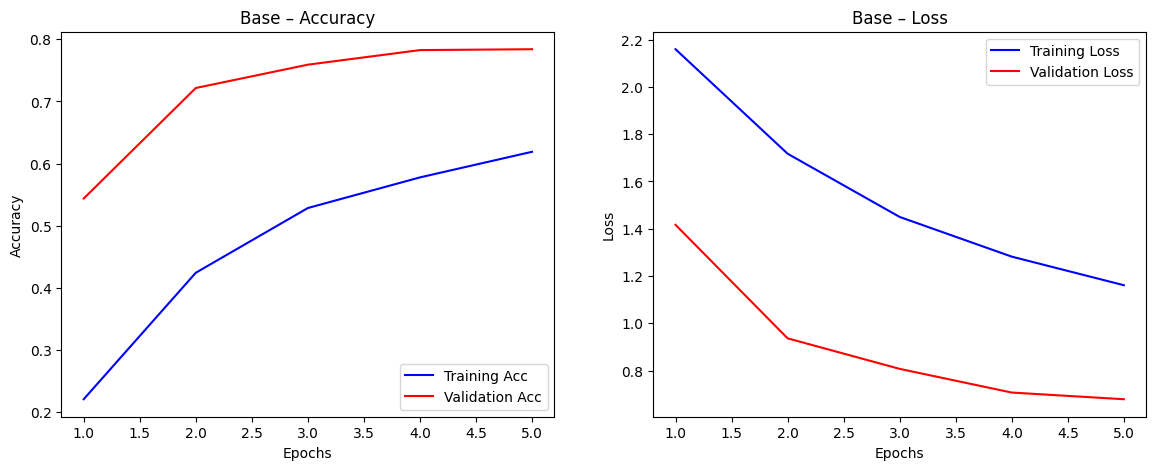

In [15]:
import matplotlib.pyplot as plt

acc = best_history.history['accuracy']
val_acc = best_history.history['val_accuracy']
loss = best_history.history['loss']
val_loss = best_history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b-', label='Training Acc')
plt.plot(epochs, val_acc, 'r-', label='Validation Acc')
plt.title(f'{best_name} – Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title(f'{best_name} – Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()


### 10. Evaluación final del modelo

Para medir el desempeño real del modelo ganador, se realiza una evaluación directa sobre el conjunto de prueba (test_ds). Esta evaluación ofrece dos métricas fundamentales:

Test accuracy: qué porcentaje de dígitos nuevos es capaz de clasificar correctamente.

Test loss: medida del error al realizar las predicciones en datos nunca vistos.


In [16]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}")


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8269 - loss: 0.5285
Test accuracy: 0.8269, Test loss: 0.5285


###  11. Entrenamiento final del modelo ganador

En esta etapa se toma el modelo ganador y se entrena nuevamente para obtener su versión definitiva.
Esto se hace porque, al comparar todos los modelos previos, el modelo seleccionado demostró ser el que mejor generaliza y ofrece el mejor desempeño.

Para este entrenamiento final se utiliza:
- EarlyStopping, que detiene el entrenamiento si la precisión de validación deja de mejorar durante 5 épocas.
- Los mismos conjuntos de entrenamiento y validación, para mantener coherencia metodológica.
- Hasta 30 épocas, aunque EarlyStopping asegura no entrenar de más.

In [17]:
from tensorflow.keras.callbacks import EarlyStopping

final_model = best_model

early_stop_final = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

history_final = final_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop_final]
)


Epoch 1/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.3813 - loss: 1.7939 - val_accuracy: 0.6427 - val_loss: 1.0901
Epoch 2/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.4686 - loss: 1.5694 - val_accuracy: 0.7192 - val_loss: 0.8855
Epoch 3/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.5421 - loss: 1.3976 - val_accuracy: 0.7469 - val_loss: 0.8075
Epoch 4/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.5779 - loss: 1.2651 - val_accuracy: 0.7723 - val_loss: 0.7206
Epoch 5/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.6155 - loss: 1.1430 - val_accuracy: 0.7920 - val_loss: 0.6558
Epoch 6/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.6416 - loss: 1.0769 - val_accuracy: 0.8061 - val_loss: 0.6084
Epoch 7/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.6537 - loss: 1.0279 - val_accuracy: 0.7939 - val_loss: 0.6140
Epoch 8/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.6787 - loss: 0.9875 - val_accuracy: 0.8202 - v

## 12. Análisis de desempeño por clase

Además de la exactitud global, es importante analizar cómo se comporta el modelo para cada dígito de forma individual.  
Para esto se realizaron los siguientes pasos:

- Se evaluó nuevamente el modelo ganador (`best_model`) sobre el conjunto de prueba para obtener su **accuracy** y **loss** finales.
- Se generaron las predicciones para todas las imágenes de `test_ds` y se compararon con sus etiquetas reales.
- Con esta información se construyó una **matriz de confusión**, que permite visualizar en qué dígitos se equivoca más el modelo y cuáles clasifica mejor.
- Finalmente, se generó un **reporte por clase** (`classification_report`), donde se muestran métricas como *precision*, *recall* y *f1-score* para cada dígito del 0 al 9.



30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8360 - loss: 0.4818
Test accuracy (Base): 0.8360
Test loss (Base): 0.4818


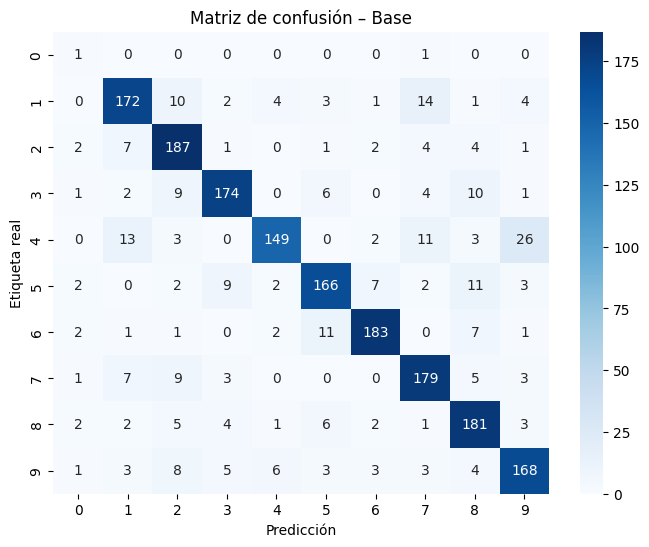

              precision    recall  f1-score   support

           0       0.08      0.50      0.14         2
           1       0.83      0.82      0.82       211
           2       0.80      0.89      0.84       209
           3       0.88      0.84      0.86       207
           4       0.91      0.72      0.80       207
           5       0.85      0.81      0.83       204
           6       0.92      0.88      0.90       208
           7       0.82      0.86      0.84       207
           8       0.80      0.87      0.84       207
           9       0.80      0.82      0.81       204

    accuracy                           0.84      1866
   macro avg       0.77      0.80      0.77      1866
weighted avg       0.84      0.84      0.84      1866



In [19]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# 1. Evaluación global en test
test_loss_best, test_acc_best = best_model.evaluate(test_ds)
print(f"Test accuracy ({best_name}): {test_acc_best:.4f}")
print(f"Test loss ({best_name}): {test_loss_best:.4f}")

# 2. Obtener todas las predicciones en test
y_true = []
y_pred = []

for images, labels in test_ds:
    probs = best_model.predict(images, verbose=0)
    y_pred.extend(np.argmax(probs, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# 3. Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta real')
plt.title(f'Matriz de confusión – {best_name}')
plt.show()

# 4. Reporte por clase
print(classification_report(y_true, y_pred))


## 13. Visualización de errores de clasificación

Para complementar el análisis cuantitativo, se realiza una inspección visual de algunas imágenes que el modelo clasificó de manera incorrecta. Esto permite observar patrones comunes en los errores y entender mejor qué tipo de dígitos representan un mayor desafío.

Los pasos realizados en esta celda fueron:

- Se identificaron todos los índices donde la predicción del modelo no coincide con la etiqueta real.
- Se imprimió la cantidad total de errores cometidos en el conjunto de prueba.
- Se seleccionaron las primeras imágenes mal clasificadas y se mostraron junto con:
  - **La etiqueta real** del dígito.
  - **La predicción del modelo** para esa imagen.

Esta visualización permite detectar casos como:
- Dígitos con trazos confusos o incompletos.
- Variaciones de escritura muy irregulares.
- Imágenes con ruido o iluminación inconsistente.
- Dígitos cuya forma se parece fuertemente a otra clase.

De esta manera, se obtiene una perspectiva más cualitativa del rendimiento del modelo y se identifican posibles áreas de mejora para futuros entrenamientos.


Cantidad de errores: 306


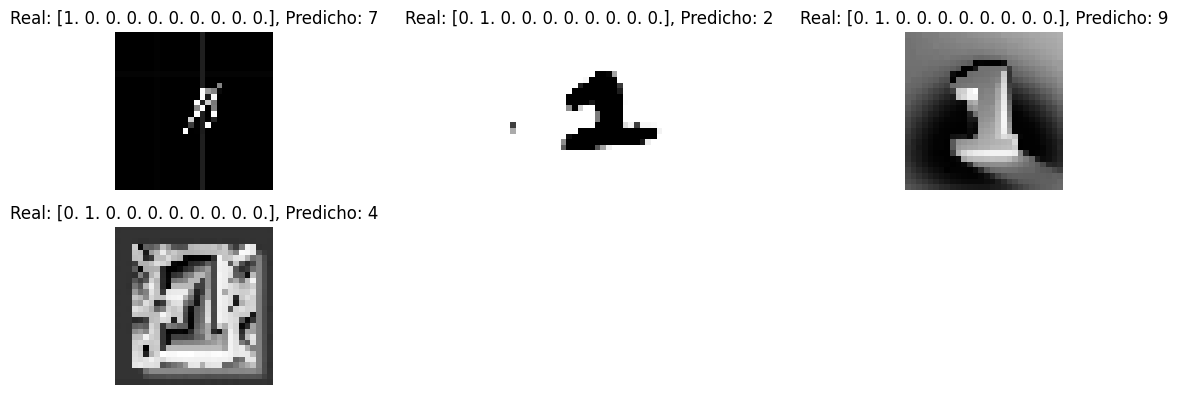

In [21]:
wrong_idx = [i for i, (t,p) in enumerate(zip(y_true, y_pred)) if t != p]

print("Cantidad de errores:", len(wrong_idx))

plt.figure(figsize=(12,6))
for i, idx in enumerate(wrong_idx[:4]):
    img, true_label = list(test_ds.unbatch().take(idx+1))[-1]
    plt.subplot(3,3,i+1)
    plt.imshow(img.numpy().squeeze(), cmap='gray')
    plt.title(f"Real: {true_label}, Predicho: {y_pred[idx]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


## 14. Prueba final del modelo entrenado y guardado

Una vez obtenido el modelo definitivo, este se guarda en formato HDF5 (`final_cnn_model.h5`) para poder reutilizarlo posteriormente, especialmente en la etapa de predicción en vivo. Guardar el modelo asegura que no sea necesario volver a entrenarlo y que pueda cargarse fácilmente desde cualquier script externo.

Después de guardar el modelo, se realiza una prueba rápida tomando una imagen del conjunto de prueba (`test_ds`), donde se hace:
1. Seleccionar una imagen real del dataset.
2. Prepararla en el formato adecuado: `(1, 28, 28, 1)`.
3. Obtener la predicción con `final_model.predict()`.
4. Comparar visualmente:
   - **Etiqueta real** del dígito.
   - **Etiqueta predicha** por el modelo.


Modelo guardado como final_cnn_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


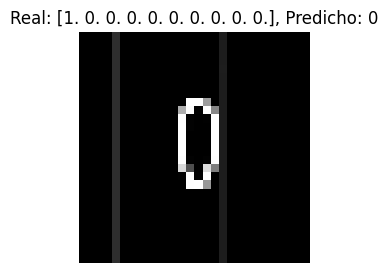

In [28]:
final_model.save("final_cnn_model.h5")
print("Modelo guardado como final_cnn_model.h5")

# Tomar una imagen de prueba
for img, label in test_ds.take(1):
    sample = img[0].numpy()
    sample_batch = sample.reshape(1, 28, 28, 1)

    pred = final_model.predict(sample_batch)
    pred_class = np.argmax(pred)

    plt.figure(figsize=(3,3))
    plt.imshow(sample.squeeze(), cmap='gray')
    plt.title(f"Real: {label[0].numpy()}, Predicho: {pred_class}")
    plt.axis('off')
    plt.show()
